<a href="https://colab.research.google.com/github/Enzo-Kerkhof/TM10007_PROJECT/blob/master/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment ADNI Dataset

Bram Gerritse 4462599  
Saskia Bijl 4439457    
Karan Ramsodit 4363043  
Enzo Kerkhof 44488555


### 1. Install git repo:

In [39]:
# Run this to use from colab environment to install git repo
!pip install -q --upgrade git+https://github.com/Enzo-Kerkhof/TM10007_PROJECT.git

# Use the @ to determine what branch to install. Don't use to install master.

#### 1.1. Import used libraries

In [0]:
from pathlib import Path
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.stats import ttest_ind
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import decomposition
from sklearn import neighbors
from sklearn import svm
from sklearn import metrics
from sklearn import feature_selection
from sklearn import ensemble
from sklearn import linear_model
from sklearn.manifold import TSNE

### 2.1. Data loading and analysis
Load the dataset with given definition. Drop the labels and plot a heatmap to show if any N/A values are in the dataset.

The dataset ABNI contains the following:

The number of samples/patients = 855
The number of columns/features = 267



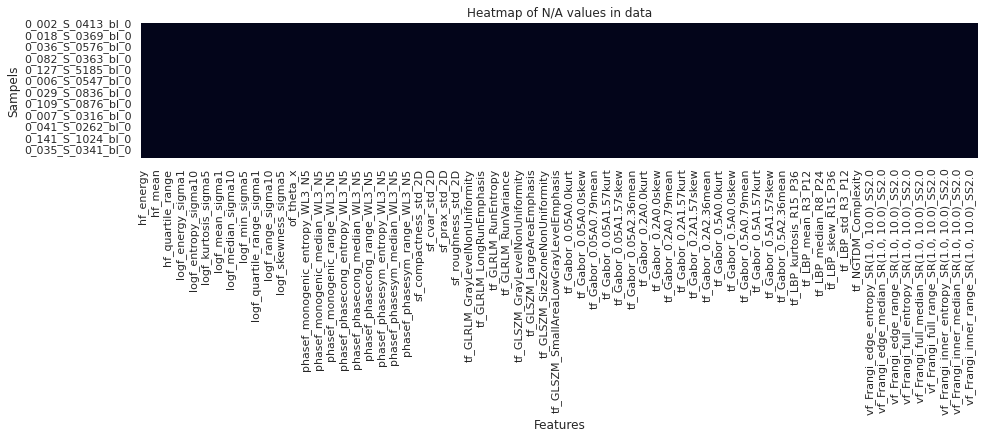

In [41]:
# Import premade data loading function
from adni.load_data import load_data

data = load_data()

# Drop labels from dataframe
X = data.drop(['label'], axis=1)

print('The dataset ABNI contains the following:\n')
print(f'The number of samples/patients = {len(X.index)}')
print(f'The number of columns/features = {len(X.columns)}\n')

# Heatmap to check number of n/a
pd.options.mode.use_inf_as_na = True
plt.figure(figsize=(15, 2.5))
sns.heatmap(X.isnull(), cbar=False)
plt.title('Heatmap of N/A values in data')
plt.xlabel('Features')
plt.ylabel('Sampels')
plt.show()

### 2.2. Data preprocessing and splitting
Binerize the labels and split the dataset in a train and test set.

In [0]:
# Binerize labels CN = 0, AD = 1
Y = preprocessing.label_binarize(data['label'], ['CN', 'AD'])
Y = [i[0] for i in Y]

# Split data
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.33)

# Reshape and convert to arrays
y_train=np.asarray(y_train).reshape([len(y_train),])
y_test=np.asarray(y_test).reshape([len(y_test),])
X_train=X_train.to_numpy()
X_test=X_test.to_numpy()

### 3.1. Visualization of the problem: TSNE Plot
The t-SNE plot reduces the dimensions of the data to 3 which allows for **vizualization** in 3D and a clear view of the relationship within the data. (If there are any.)

In [0]:
# Perform manifolds TSNE on full dataset
tsne = TSNE(n_components=3, perplexity=30, n_iter=2000)
X_TSNE = tsne.fit_transform(X)

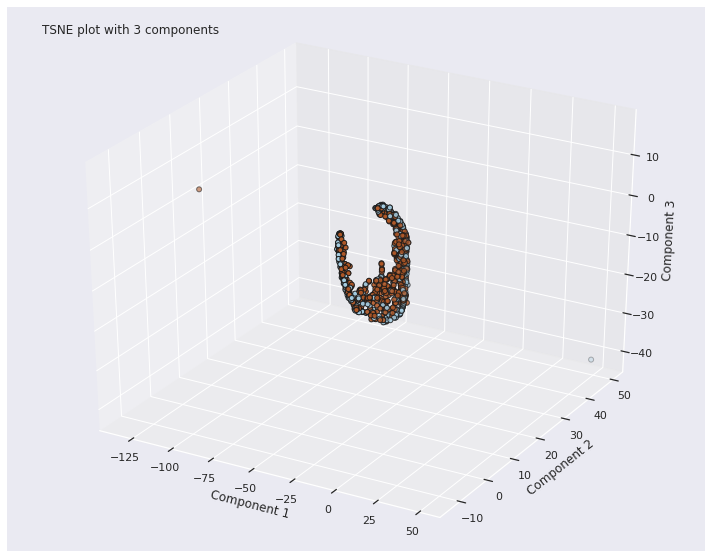

In [44]:
# Plot 3D of TSNE components
fig = plt.figure(figsize=(12.5, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_TSNE[:,0], X_TSNE[:,1], X_TSNE[:,2], marker='o', c=Y,s=25, edgecolor='k',
            cmap=plt.cm.Paired)
ax.text2D(0.05, 0.95, "TSNE plot with 3 components", transform=ax.transAxes)
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")
plt.show()

### 3.2. Feature selection: Reduce complexity of amount of features

Apply 2-sampled T-test for feature selection 

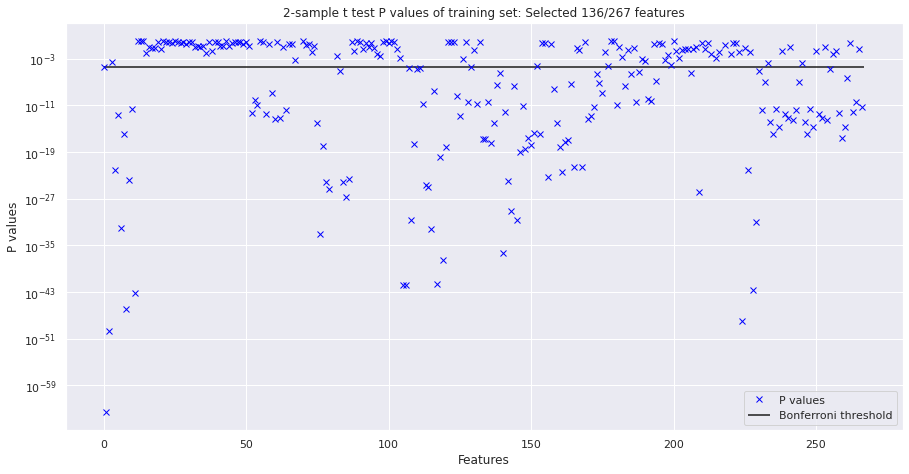

In [45]:
# Create function to get indices
np.seterr(invalid='ignore')
get_indices = lambda dataToMatch, inputData: [i for (y, i) in zip(inputData, range(len(inputData))) 
                                              if dataToMatch == y]

# Calculate Bonferroni correction
Bonferroni_corrected_alpha = 0.01/(X.shape[1])

# Get indices of labels
ad_samplsIndex = get_indices(1, y_train)
cn_sampleIndex = get_indices(0, y_train)

ad_data = X_train[ad_samplsIndex, :]
cn_data = X_train[cn_sampleIndex, :]

# Preform t-test
[t_values, p_values]=ttest_ind(ad_data, cn_data)

get_indices_smallerThen = lambda dataToMatch, inputData: [i for (y, i) in zip(inputData, range(len(inputData))) 
                                                          if dataToMatch <= y]

# Get significant p values only
significant_p_valueIndices = get_indices_smallerThen(Bonferroni_corrected_alpha,
                                                     p_values)

# Feature selected dataset
X_train_selected = X_train[:,significant_p_valueIndices]
X_test_selected = X_test[:,significant_p_valueIndices]

# Show p values and the bonferroni threshold
plt.figure(figsize=(15, 7.5))
plt.plot(p_values, 'x', color='blue', label='P values')
plt.hlines(Bonferroni_corrected_alpha, 0, X.shape[1],
           label='Bonferroni threshold')
plt.xlabel('Features')
plt.ylabel('P values')
plt.yscale('log')
plt.title(f'2-sample t test P values of training set: '
          f'Selected {X_train_selected.shape[1]}/{X.shape[1]} features')
plt.legend()
plt.show()


### 3.3. Feature scaling: Reduce outliers, preprocess for PCA and classifiers

Scale features using the Min-Max scaler for the classifiers.
A plot of the mean and standard deviation of all selected features before and after scaling is shown.

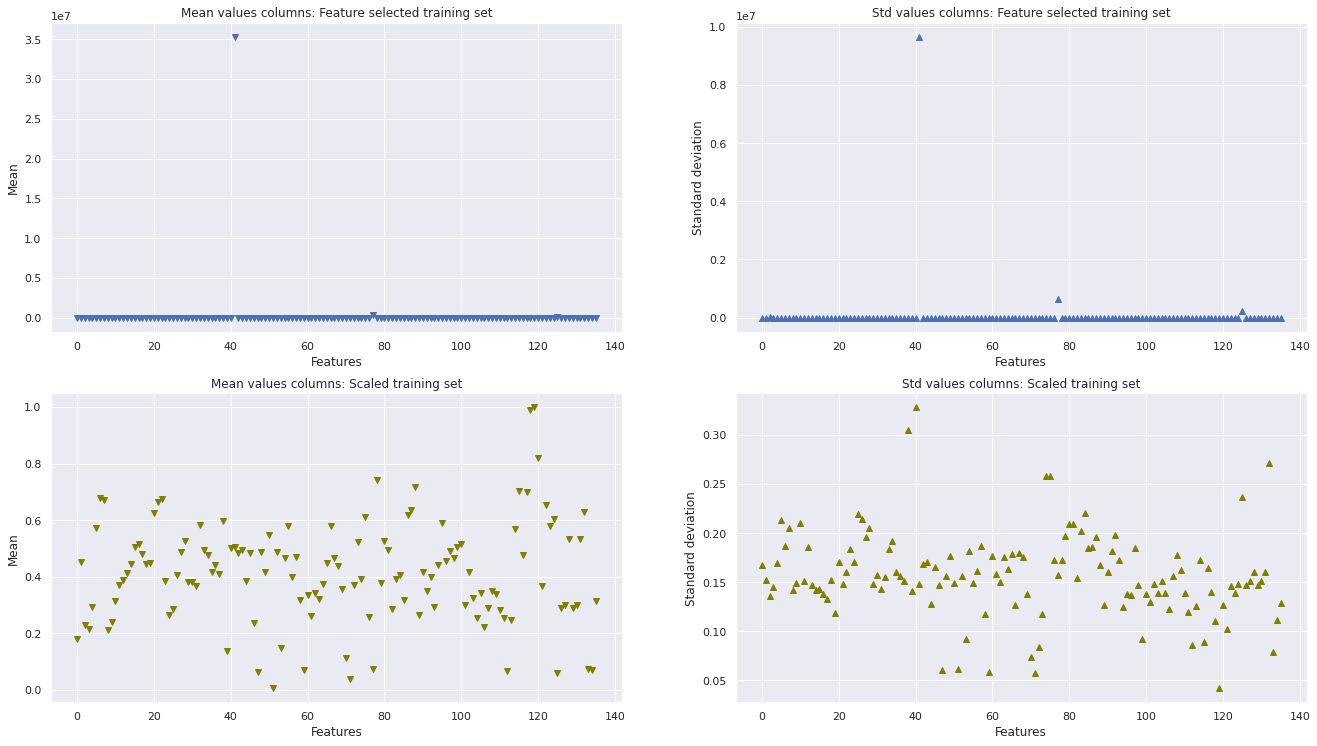

In [46]:
# Scale the data
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train_selected)
X_train_scaled = scaler.transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Retrieve data statistics
data_statistics_selected = pd.DataFrame(X_train_selected).describe()
data_statistics_scaled = pd.DataFrame(X_train_scaled).describe()

# Plot figure of mean and std before and after scaling
fig = plt.figure(figsize=(22.5,12.5))

ax = fig.add_subplot(221)
ax.plot(range(X_train_selected.shape[1]),
        data_statistics_selected.loc['mean',:], 'v')
ax.set_xlabel('Features')
ax.set_ylabel('Mean')
ax.set_title("Mean values columns: Feature selected training set")

ax = fig.add_subplot(222)
ax.plot(range(X_train_selected.shape[1]),
        data_statistics_selected.loc['std',:], '^')
ax.set_xlabel('Features')
ax.set_ylabel('Standard deviation')
ax.set_title("Std values columns: Feature selected training set")

ax = fig.add_subplot(223)
ax.plot(range(X_train_scaled.shape[1]),
        data_statistics_scaled.loc['mean',:], 'v', color='olive')
ax.set_xlabel('Features')
ax.set_ylabel('Mean')
ax.set_title("Mean values columns: Scaled training set")

ax = fig.add_subplot(224)
ax.plot(range(X_train_scaled.shape[1]),
        data_statistics_scaled.loc['std',:], '^', color='olive')
ax.set_xlabel('Features')
ax.set_ylabel('Standard deviation')
ax.set_title("Std values columns: Scaled training set")
plt.show()

### 3.4. Perform Principal Component Analysis: Reduce the dimensionality
PCA on scaled and selected features. Plot the Cumulative explained variance to see the added variance per eigenvalue.

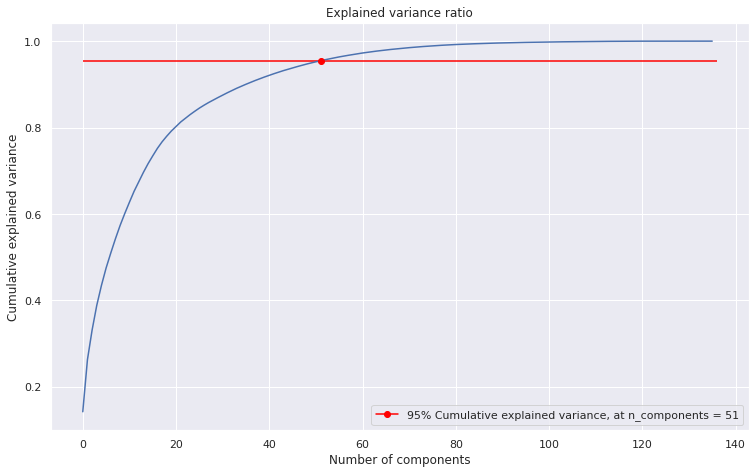

In [47]:
# Perform PCA with all components
pca = decomposition.PCA()
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
cumsum=np.cumsum(pca.explained_variance_ratio_)
d=np.argmax(cumsum>=0.95)+1

# Plot Cumulative explained variance
plt.figure(figsize=(12.5, 7.5))
plt.plot(cumsum)
plt.plot(d, cumsum[d],'-o', color='red',
         label=f'95% Cumulative explained variance, at n_components = {d}')
plt.hlines(cumsum[d], 0, cumsum.shape[0], color='red')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Explained variance ratio')
plt.legend()
plt.show()

# Perform PCA with reduced amount of components
pca = decomposition.PCA(n_components=d)
X_train = pca.fit_transform(X_train_scaled)
X_test = pca.transform(X_test_scaled)

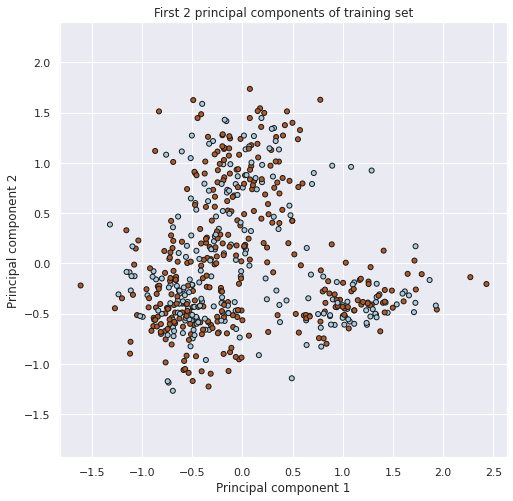

In [48]:
# Plot the first two components of the PCA with the true labels as colours
plt.figure(figsize=(8, 8))
plt.scatter(X_train[:, 0], X_train[:, 1], marker='o',
            c=y_train, s=25, edgecolor='k',
            cmap=plt.cm.Paired);
plt.title('First 2 principal components of training set')
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.axis('equal')
plt.show()

As seen in the plot above, the problem is still multi dimentional. The first 2 components of the PCA have a very large overlap in the scatterplot. The problem remains complex and we are going to have to use a complex classifier.


# 4. Fit classifiers
### Try different classifiers (and different hyperparameters).

In [0]:
# Dict to save the found classifiers
best_classifiers = {}

### 4.1. Find best classifier using Randomized Search CV
Definition to find best classifier for input parameters and print the results. Using the ROC_AUC score, 10 fold CV and 100 iterations.

In [0]:
def find_best_clf(classifier, param_distributions):
    '''
    Definition to find optimal parameters for given classifier
    and the preprocessed ADNI dataset.
    '''
    # Randomized search crossvalidation
    clf = model_selection.RandomizedSearchCV(classifier,
                                            param_distributions, cv=10,
                                            n_iter=100, scoring='roc_auc')
    clf.fit(X_train, y_train)

    # Train scores
    probabilities_train = clf.best_estimator_.predict_proba(X_train)
    scores_train = probabilities_train[:, 1]
    auc_train = metrics.roc_auc_score(y_train, scores_train)

    # Test scores
    predictions = clf.best_estimator_.predict(X_test)
    probabilities_test = clf.best_estimator_.predict_proba(X_test)
    scores_test = probabilities_test[:, 1]
    auc_test = metrics.roc_auc_score(y_test, scores_test)

    # Print results
    print(f'The optimal parameters for this dataset are:\n')
    print(f'\t {clf.best_estimator_.__class__.__name__}')
    print(f'\t {clf.best_params_}')
    print('\t The other parameters are left default.')
    print(f'\nThe ROC_AUC of this estimator on the train set is: {auc_train:.3f}')
    print(f'The ROC_AUC of this estimator on the test set is: {auc_test:.3f}')
    print(f'\nConfusion matrix for {clf.best_estimator_.__class__.__name__}:\n')
    print(metrics.confusion_matrix(y_pred=predictions, y_true=y_test))
    print(f'\nClassification report for {clf.best_estimator_.__class__.__name__}:\n')
    print(metrics.classification_report(y_pred=predictions, y_true=y_test))

    return clf.best_estimator_

### 4.2. K-NearestNeighbor with optimal N
First plot to show the train and validation scores with range of N.
Then an implemented crossvalidation gridsearch to choose the optimal N.

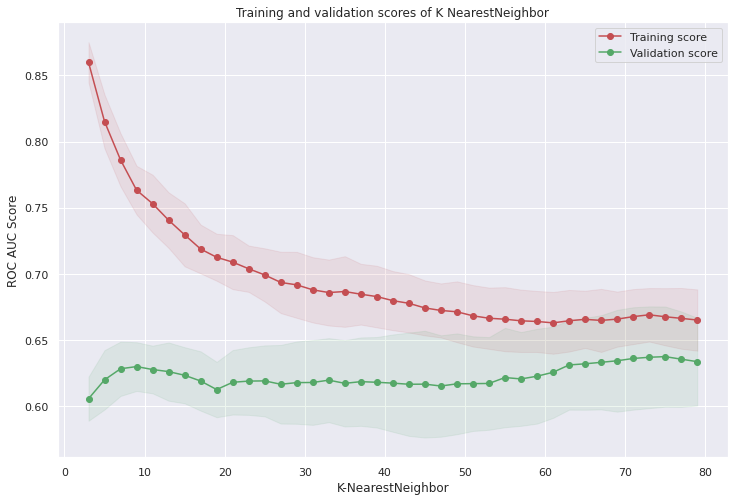

In [51]:
k_list = list(range(3, 80, 2))
all_train = []
all_test = []

# Use 20 random splits in which class balance is retained
sss = model_selection.StratifiedShuffleSplit(n_splits=20, test_size=0.5)

for train_index, test_index in sss.split(X_train, y_train):
    train_scores = []
    test_scores = []
    
    split_X_train = X_train[train_index]
    split_y_train = y_train[train_index]
    split_X_test = X_train[test_index]
    split_y_test = y_train[test_index]

    for k in k_list:
        clf_knn = neighbors.KNeighborsClassifier(n_neighbors=k)
        clf_knn.fit(split_X_train, split_y_train)

        # Test the classifier on the training data and plot
        train_proba = clf_knn.predict_proba(split_X_train)[:, 1]
        test_proba = clf_knn.predict_proba(split_X_test)[:, 1]
        
        score_train = metrics.roc_auc_score(split_y_train, train_proba)
        score_test = metrics.roc_auc_score(split_y_test, test_proba)
        

        train_scores.append(score_train)
        test_scores.append(score_test)
        
    all_train.append(train_scores)
    all_test.append(test_scores)
    

# Create numpy array of scores and calculate the mean and std
all_train = np.array(all_train)
all_test = np.array(all_test)

train_scores_mean = all_train.mean(axis=0)
train_scores_std = all_train.std(axis=0)

test_scores_mean = all_test.mean(axis=0)
test_scores_std = all_test.std(axis=0)

# Plot the mean scores and the std as shading
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.fill_between(k_list, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
ax.fill_between(k_list, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
ax.plot(k_list, train_scores_mean, 'o-', color="r",
        label="Training score")
ax.plot(k_list, test_scores_mean, 'o-', color="g",
        label="Validation score")
ax.set_xlabel('K-NearestNeighbor')
ax.set_ylabel('ROC AUC Score')
ax.set_title('Training and validation scores of K NearestNeighbor')
ax.legend()
plt.show()

In [52]:
# Create a stratified CV iterator
cv_20fold = model_selection.StratifiedKFold(n_splits=20)
results = []
best_n_neighbors = []

# Loop over the folds
for validation_index, test_index in cv_20fold.split(X_train, y_train):

    # Split data
    X_validation = X_train_pca[validation_index]
    y_validation = y_train[validation_index]
    
    X_validation_test = X_train_pca[test_index]
    y_validation_test = y_train[test_index]
    
    # Create a grid search to find the optimal k
    parameters = {"n_neighbors": list(range(3, 80, 2))}
    knn = neighbors.KNeighborsClassifier()
    cv_10fold = model_selection.StratifiedKFold(n_splits=10)
    grid_search = model_selection.GridSearchCV(knn, parameters,
                                               cv=cv_10fold, scoring='roc_auc')
    grid_search.fit(X_validation, y_validation)
    
    # Get resulting classifier
    clf = grid_search.best_estimator_
    best_n_neighbors.append(clf.n_neighbors)
    
    # Test the classifier on the test data
    probabilities = clf.predict_proba(X_validation_test)
    scores = probabilities[:, 1]
    
    # Get the auc
    auc = metrics.roc_auc_score(y_validation_test, scores)
    results.append({
        'auc': auc,
        'k': clf.n_neighbors,
        'set': 'test'
    })
    
    # Test the classifier on the validation data
    probabilities_validation = clf.predict_proba(X_validation)
    scores_validation = probabilities_validation[:, 1]
    
    # Get the auc
    auc_validation = metrics.roc_auc_score(y_validation, scores_validation)
    results.append({
        'auc': auc_validation,
        'k': clf.n_neighbors,
        'set': 'validation'
    })
    
# Create results dataframe and plot it
results = pd.DataFrame(results)

optimal_n = int(np.median(best_n_neighbors))

# Fit KNN
clf = neighbors.KNeighborsClassifier(n_neighbors=optimal_n)
clf.fit(X_train, y_train)

# Train score
probabilities_train = clf.predict_proba(X_train)
scores_train = probabilities_train[:, 1]
auc_train = metrics.roc_auc_score(y_train, scores_train)

# Test score
predictions = clf.predict(X_test)
probabilities_test = clf.predict_proba(X_test)
scores_test = probabilities_test[:, 1]
auc_test = metrics.roc_auc_score(y_test, scores_test)

# Save best estimator
best_classifiers[clf.__class__.__name__] = clf

# Print results
print(f"The optimal N={optimal_n}\n")
print(f'The ROC_AUC on the train set is {auc_train:.3f} using a '
      f'{clf.n_neighbors}-{clf.__class__.__name__}')
print(f'The ROC_AUC on the test set is {auc_test:.3f} using a '
      f'{clf.n_neighbors}-{clf.__class__.__name__}')
print(f'\nConfusion matrix for {clf.__class__.__name__}:\n')
print(metrics.confusion_matrix(y_pred=predictions, y_true=y_test))
print(f'\nClassification report for {clf.__class__.__name__}:\n')
print(metrics.classification_report(y_pred=predictions, y_true=y_test))


The optimal N=15

The ROC_AUC on the train set is 0.769 using a 15-KNeighborsClassifier
The ROC_AUC on the test set is 0.731 using a 15-KNeighborsClassifier

Confusion matrix for KNeighborsClassifier:

[[ 49  55]
 [ 33 146]]

Classification report for KNeighborsClassifier:

              precision    recall  f1-score   support

           0       0.60      0.47      0.53       104
           1       0.73      0.82      0.77       179

    accuracy                           0.69       283
   macro avg       0.66      0.64      0.65       283
weighted avg       0.68      0.69      0.68       283



### 4.3. Logistic Regression model
Randomized crossvalidation with a few hyperparameters in order to find an optimal logistic regression classifier.

In [53]:
# Classifier to use
classifier = linear_model.LogisticRegression()

# Hyperparameters to optimizatize
param_distributions = {'penalty' : ['l2'],
                       'C' : np.arange(0.001, 1, 0.001),
                       'solver' : ['sag', 'saga']
                       }

# Find best classifier using Random Search CV and print results
clf = find_best_clf(classifier, param_distributions)

# Save best classifier
best_classifiers[clf.__class__.__name__] = clf

The optimal parameters for this dataset are:

	 LogisticRegression
	 {'solver': 'sag', 'penalty': 'l2', 'C': 0.428}
	 The other parameters are left default.

The ROC_AUC of this estimator on the train set is: 0.827
The ROC_AUC of this estimator on the test set is: 0.847

Confusion matrix for LogisticRegression:

[[ 67  37]
 [ 23 156]]

Classification report for LogisticRegression:

              precision    recall  f1-score   support

           0       0.74      0.64      0.69       104
           1       0.81      0.87      0.84       179

    accuracy                           0.79       283
   macro avg       0.78      0.76      0.76       283
weighted avg       0.78      0.79      0.78       283



### 4.4. Support vector machine
Randomized crossvalidation with a few hyperparameters in order to find an optimal SVM for the training set.

In [54]:
# Classifier to use
classifier = svm.SVC(probability=True)

# Hyperparameters to optimizatize
param_distributions = {'C': np.arange(0.001, 1, 0.001),
                       'gamma': ['scale', 'auto']
                       }

# Find best classifier using Random Search CV and print results
clf = find_best_clf(classifier, param_distributions)

# Save best classifier
best_classifiers[clf.__class__.__name__] = clf

The optimal parameters for this dataset are:

	 SVC
	 {'gamma': 'scale', 'C': 0.995}
	 The other parameters are left default.

The ROC_AUC of this estimator on the train set is: 0.975
The ROC_AUC of this estimator on the test set is: 0.839

Confusion matrix for SVC:

[[ 60  44]
 [ 23 156]]

Classification report for SVC:

              precision    recall  f1-score   support

           0       0.72      0.58      0.64       104
           1       0.78      0.87      0.82       179

    accuracy                           0.76       283
   macro avg       0.75      0.72      0.73       283
weighted avg       0.76      0.76      0.76       283



### 4.5. Random forest classifier
Randomized crossvalidation with a few hyperparameters in order to find an optimal Random Forest for the training set.

In [55]:
# Classifier to use
classifier = ensemble.RandomForestClassifier()

# Hyperparameters to optimizatize
param_distributions = {'n_estimators': range(20, 110),
                       'max_depth': range(1, 50),
                       'max_leaf_nodes': range(20, 110)
                       }

# Find best classifier using Random Search CV and print results
clf = find_best_clf(classifier, param_distributions)

# Save best classifier
best_classifiers[clf.__class__.__name__] = clf


The optimal parameters for this dataset are:

	 RandomForestClassifier
	 {'n_estimators': 91, 'max_leaf_nodes': 35, 'max_depth': 7}
	 The other parameters are left default.

The ROC_AUC of this estimator on the train set is: 1.000
The ROC_AUC of this estimator on the test set is: 0.809

Confusion matrix for RandomForestClassifier:

[[ 39  65]
 [  7 172]]

Classification report for RandomForestClassifier:

              precision    recall  f1-score   support

           0       0.85      0.38      0.52       104
           1       0.73      0.96      0.83       179

    accuracy                           0.75       283
   macro avg       0.79      0.67      0.67       283
weighted avg       0.77      0.75      0.71       283



### 4.5.1. Influence of number of trees on found Random Forest Classifier

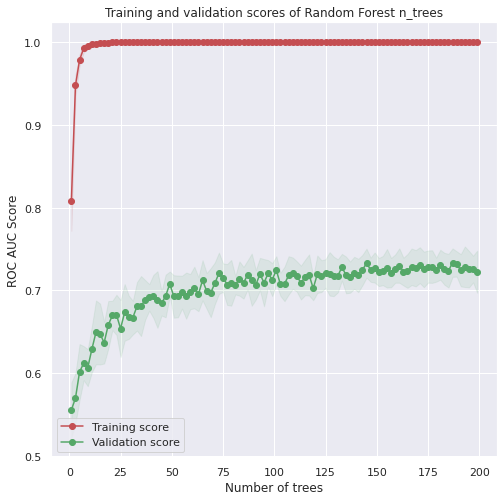

In [56]:
n_trees = list(range(1, 200, 2))
leaf_nodes = best_classifiers['RandomForestClassifier'].max_leaf_nodes
depth = best_classifiers['RandomForestClassifier'].max_depth

all_train = []
all_test = []

sss = model_selection.StratifiedShuffleSplit(n_splits=10, test_size=0.5)

for train_index, test_index in sss.split(X_train, y_train):
    train_scores = []
    test_scores = []
    
    split_X_train = X_train[train_index]
    split_y_train = y_train[train_index]
    split_X_test = X_train[test_index]
    split_y_test = y_train[test_index]

    for trees in n_trees:
        clf = ensemble.RandomForestClassifier(n_estimators=trees,
                                              max_leaf_nodes=leaf_nodes,
                                              max_depth=depth)
        clf.fit(split_X_train, split_y_train)

        # Test the classifier on the training data and plot
        train_proba = clf.predict_proba(split_X_train)[:, 1]
        test_proba = clf.predict_proba(split_X_test)[:, 1]
        
        score_train = metrics.roc_auc_score(split_y_train, train_proba)
        score_test = metrics.roc_auc_score(split_y_test, test_proba)
        

        train_scores.append(score_train)
        test_scores.append(score_test)
        
    all_train.append(train_scores)
    all_test.append(test_scores)
    

# Create numpy array of scores and calculate the mean and std
all_train = np.array(all_train)
all_test = np.array(all_test)

train_scores_mean = all_train.mean(axis=0)
train_scores_std = all_train.std(axis=0)

test_scores_mean = all_test.mean(axis=0)
test_scores_std = all_test.std(axis=0)

# Plot the mean scores and the std as shading
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.fill_between(n_trees, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
ax.fill_between(n_trees, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
ax.plot(n_trees, train_scores_mean, 'o-', color="r",
        label="Training score")
ax.plot(n_trees, test_scores_mean, 'o-', color="g",
        label="Validation score")
ax.set_xlabel('Number of trees')
ax.set_ylabel('ROC AUC Score')
ax.set_title('Training and validation scores of Random Forest n_trees')
ax.legend()
plt.show()

## 5. Plot of Receiver Operating Curve for all models

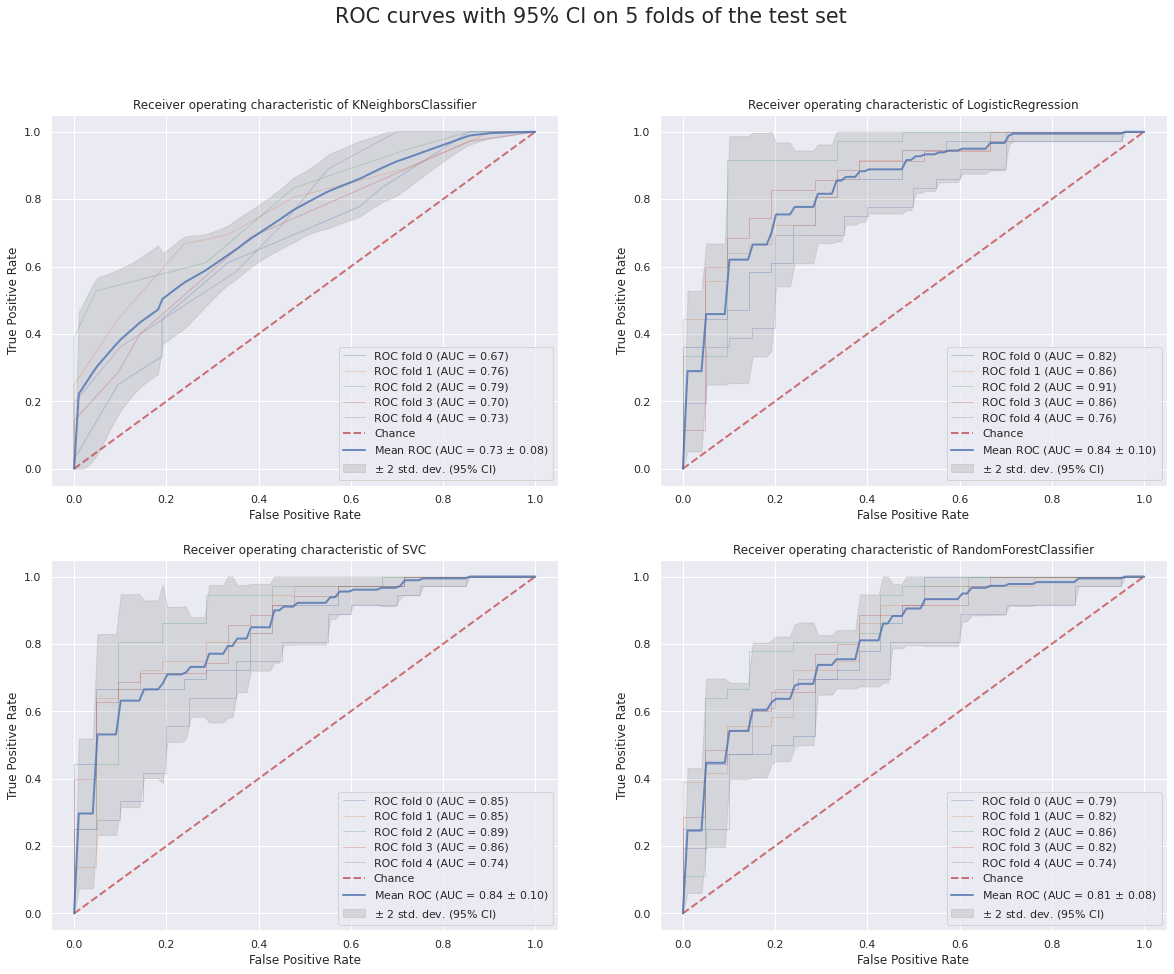

In [57]:
# Create figure
fig = plt.figure(figsize=(20, 15))

# Iterate through all found classifiers
for number, clf in enumerate(best_classifiers):
    
    # Create cv object
    cv = model_selection.StratifiedKFold(n_splits=5)
    classifier = best_classifiers[clf]

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    ax = fig.add_subplot(2, 2, number+1)
    
    # Test classfier on 5 folds
    for i, (train, test) in enumerate(cv.split(X_test, y_test)):
        viz = metrics.plot_roc_curve(classifier, X_test[test], y_test[test],
                                    name='ROC fold {}'.format(i),
                                    alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    # Plot chance line
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    # Calculate mean and standard deviation
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, 2*std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + 2*std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - 2*std_tpr, 0)
    
    # Plot 95% (95.45%) CI with 2 times the std
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 2 std. dev. (95% CI)')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
          title=f"Receiver operating characteristic of {clf}")
    ax.legend(loc="lower right")

plt.suptitle('ROC curves with 95% CI on 5 folds of the test set',
             fontsize='xx-large')
plt.show()